## Interpolate one or multiple frames between two imagem

In [1]:
import os
from pathlib import Path
import numpy as np
import tempfile
import tensorflow as tf
import mediapy
import cv2
from PIL import Image, ExifTags

from natsort import natsorted
import shutil

import math
import mediapy as media
from typing import Generator, Iterable, List, Optional, Union


from eval import interpolator, util
import fix_images

2025-01-09 23:08:23.686471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-09 23:08:24.454330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/sparsh/miniconda3/envs/tf/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
# Download the pretrained model
import gdown
os.makedirs('pretrained_models/film_net/Style/saved_model', exist_ok=True)

if os.path.exists('pretrained_models/film_net/Style/saved_model/saved_model.pb'):
    print('Model already downloaded')
else:
    folder_url = 'https://drive.google.com/drive/folders/1i9Go1YI2qiFWeT5QtywNFmYAA74bhXWj'
    gdown.download_folder(folder_url, output='pretrained_models/film_net/Style/saved_model', quiet=False)

Retrieving folder contents


Retrieving folder 1NSex_z_Mm13nobMRDyS6JeXLPhW3bREz assets
Retrieving folder 1s9pbFx_bSbinhx5PChJwZqPsyRIlehmZ variables
Processing file 1_oyM-LBAK9o7-bNWf1jG8VvBYeqpmSUr variables.data-00000-of-00001
Processing file 1ceC2kbJs3U1dMMrp4hNIpoHRFxO33SFC variables.index
Processing file 1dT85Z-HyYsiUgIQbOgYFjwWPOw8en1RC keras_metadata.pb
Processing file 1nfi15im3LQvCx84ZRiNcfMuodDkRL_Ei saved_model.pb


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1_oyM-LBAK9o7-bNWf1jG8VvBYeqpmSUr
From (redirected): https://drive.google.com/uc?id=1_oyM-LBAK9o7-bNWf1jG8VvBYeqpmSUr&confirm=t&uuid=543ea468-2811-4ddf-8108-57111b47b6c5
To: /home/sparsh/programming/ml/ai_timelapse/pretrained_models/film_net/Style/saved_model/variables/variables.data-00000-of-00001
100%|██████████| 138M/138M [00:12<00:00, 11.0MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1ceC2kbJs3U1dMMrp4hNIpoHRFxO33SFC
To: /home/sparsh/programming/ml/ai_timelapse/pretrained_models/film_net/Style/saved_model/variables/variables.index
100%|██████████| 1.93k/1.93k [00:00<00:00, 5.20MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dT85Z-HyYsiUgIQbOgYFjwWPOw8en1RC
To: /home/sparsh/programming/ml/ai_timelapse/pretrained_models/film_net/Style/saved_model/keras_metadata.pb
100%|██████████| 222k/222k [00:

['pretrained_models/film_net/Style/saved_model/variables/variables.data-00000-of-00001',
 'pretrained_models/film_net/Style/saved_model/variables/variables.index',
 'pretrained_models/film_net/Style/saved_model/keras_metadata.pb',
 'pretrained_models/film_net/Style/saved_model/saved_model.pb']

In [2]:
MAX_DIM = 1080
MODEL_PATH = "pretrained_models/film_net/Style/saved_model"

In [3]:
input_dir = 'input_frames/boy'
output_dir = 'output_frames/boy'
preprocess_face = True

In [4]:
# check gpus
print("\nAvailable devices:")
for device in tf.config.list_physical_devices():
    print(device)


Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2025-01-09 23:08:51.314066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-09 23:08:51.446953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-09 23:08:51.447030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [29]:
def save_frames(frames, output_dir, format='jpg'):
    """
    Save interpolated frames to the specified output directory and return the output paths.
    Args:
        frames: List of image arrays
        output_dir: Directory to save frames
        format: Image format to save (jpg/png)
    Returns:
        list: List of file paths where the frames are saved.
    """
    output_paths = []
    for idx, frame in enumerate(frames):
        output_path = os.path.join(output_dir, f'frame_{idx:06d}.{format}')
        util.write_image(output_path, frame)
        output_paths.append(output_path)
    return output_paths

def correct_image_orientation(img: Image) -> Image:
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = dict(img._getexif().items())

        if exif[orientation] == 3:
            img = img.rotate(180, expand=True)
        elif exif[orientation] == 6:
            img = img.rotate(270, expand=True)
        elif exif[orientation] == 8:
            img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, TypeError, IndexError):
        # No EXIF data or no orientation tag
        pass
    return img



def get_new_size(image_path: str, max_dim: int = MAX_DIM) -> np.ndarray:
    """Resize the image so that the maximum dimension is `max_dim`."""
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    if h > w:
        new_h = max_dim
        new_w = int(w * new_h / h)
    else:
        new_w = max_dim
        new_h = int(h * new_w / w)
    return (new_w, new_h)

def concat_images(image_paths: List[str], target_height: int = 500) -> Image:
    """
    Concatenate multiple images horizontally with same height
    Args:
        image_paths: List of paths to images
        target_height: Height to resize images to
    Returns:
        PIL Image object with concatenated images
    """
    # Validate paths exist
    paths = [Path(p) for p in image_paths]
    if not all(p.exists() for p in paths):
        raise FileNotFoundError("One or more image paths do not exist")
        
    # Load images
    images = [correct_image_orientation(Image.open(p)) for p in paths]
    
    # Calculate widths for same height
    widths = [int(img.size[0] * target_height / img.size[1]) for img in images]
    
    # Create blank image
    total_width = sum(widths)
    combined = Image.new('RGB', (total_width, target_height))
    
    # Paste resized images
    x_offset = 0
    for img, new_width in zip(images, widths):
        resized = img.resize((new_width, target_height))
        combined.paste(resized, (x_offset, 0))
        x_offset += new_width
        
    return combined


def copy_to_temp(file_path: Union[str, Path], keep_extension: bool = True) -> str:
    source_path = Path(file_path)
    
    # Create temp file with same extension if requested
    if keep_extension:
        suffix = source_path.suffix
    else:
        suffix = None
        
    temp_file = tempfile.NamedTemporaryFile(suffix=suffix, delete=False)
    temp_path = temp_file.name
    temp_file.close()
    
    # Copy the file
    shutil.copy2(source_path, temp_path)
    
    return temp_path


def save_video(frames, out_path):
    ffmpeg_path = util.get_ffmpeg_path()
    mediapy.set_ffmpeg(ffmpeg_path)
    mediapy.write_video(out_path, frames, fps=30)

In [6]:
class Predictor():
    def setup(self):
        import tensorflow as tf
        print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
        # self.interpolator = interpolator.Interpolator(MODEL_PATH, None)
        self.interpolator = interpolator.Interpolator(MODEL_PATH, 64, [1, 1])

        # Batched time.
        self.batch_dt = np.full(shape=(1,), fill_value=0.5, dtype=np.float32)

    
    def predict(self, frame1, frame2, times_to_interpolate=1):
        INPUT_EXT = ['.png', '.jpg', '.jpeg', '.bmp']
        assert os.path.splitext(str(frame1))[-1] in INPUT_EXT and os.path.splitext(str(frame2))[-1] in INPUT_EXT, \
            "Please provide png, jpg or jpeg images."

        # make sure 2 images are the same size and within limits
        img1 = Image.open(str(frame1))
        img2 = Image.open(str(frame2))
        assert img1.size == img2.size, "Images must be the same size"

        if times_to_interpolate == 1:
            # First batched image.
            image_1 = util.read_image(str(frame1))
            image_batch_1 = np.expand_dims(image_1, axis=0)
    
            # Second batched image.
            image_2 = util.read_image(str(frame2))
            image_batch_2 = np.expand_dims(image_2, axis=0)
    
            # Invoke the model once.
            
            mid_frame = self.interpolator.interpolate(image_batch_1, image_batch_2, self.batch_dt)[0]

            return [mid_frame]


        input_frames = [str(frame1), str(frame2)]

        frames = list(
            util.interpolate_recursively_from_files(
                input_frames, times_to_interpolate, self.interpolator))

        return frames


In [61]:
files = natsorted([f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

frame1 = f'{input_dir}/{files[0]}'
frame2 = f'{input_dir}/{files[1]}'

In [62]:
if not os.path.exists(frame1) or (not os.path.exists(frame2)):
    raise Exception('Images not found')

In [65]:
# Preprocess images

#  save copy of images
orig_frame1 = frame1
orig_frame2 = frame2
frame1 = tempfile.mktemp(suffix='.jpg')
frame2 = tempfile.mktemp(suffix='.jpg')
img1 = Image.open(orig_frame1)
img2 = Image.open(orig_frame2)
img1.save(frame1)
img2.save(frame2)

# handle orientation of images
img1 = correct_image_orientation(img1)
img2 = correct_image_orientation(img2)
img1.save(frame1)
img2.save(frame2)

if preprocess_face:
    try:
        fix_images.process_face_image(
            frame1,
            frame1,
            background_color=(255, 255, 255),  # White background
            save_bbox_preview=False
            )
        fix_images.process_face_image(
            frame2,
            frame2,
            background_color=(255, 255, 255),  # White background
            save_bbox_preview=False
            )
    except Exception as e:
        print('Error in preprocessing images for face')
else:
    new_size = get_new_size(frame1)
    img1 = img1.resize(new_size)
    img2 = img2.resize(new_size)
    img1.save(frame1)
    img2.save(frame2)

INFO:fix_images:Processing image: /tmp/tmp_nby_jdd.jpg
INFO:fix_images:Image loaded successfully
libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

W0000 00:00:1736445908.204636   82000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
INFO:fix_images:Face detected successfully
INFO:fix_images:Image cropped and centered
INFO:fix_images:Image resized
INFO:fix_images:Background removed
INFO:fix_images:Processed image saved to: /tmp/tmp_nby_jdd.jpg
INFO:fix_images:Processing image: /tmp/tmps_xo094u.jpg


In [66]:
predictor = Predictor()
predictor.setup()

Num GPUs Available:  1


In [68]:
output_frames = predictor.predict(frame1, frame2, times_to_interpolate=1)

2025-01-09 23:35:12.364710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [1,1024,1024,3]
	 [[{{node inputs}}]]


In [69]:
# save output frames
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)
output_images = save_frames(output_frames, output_dir)

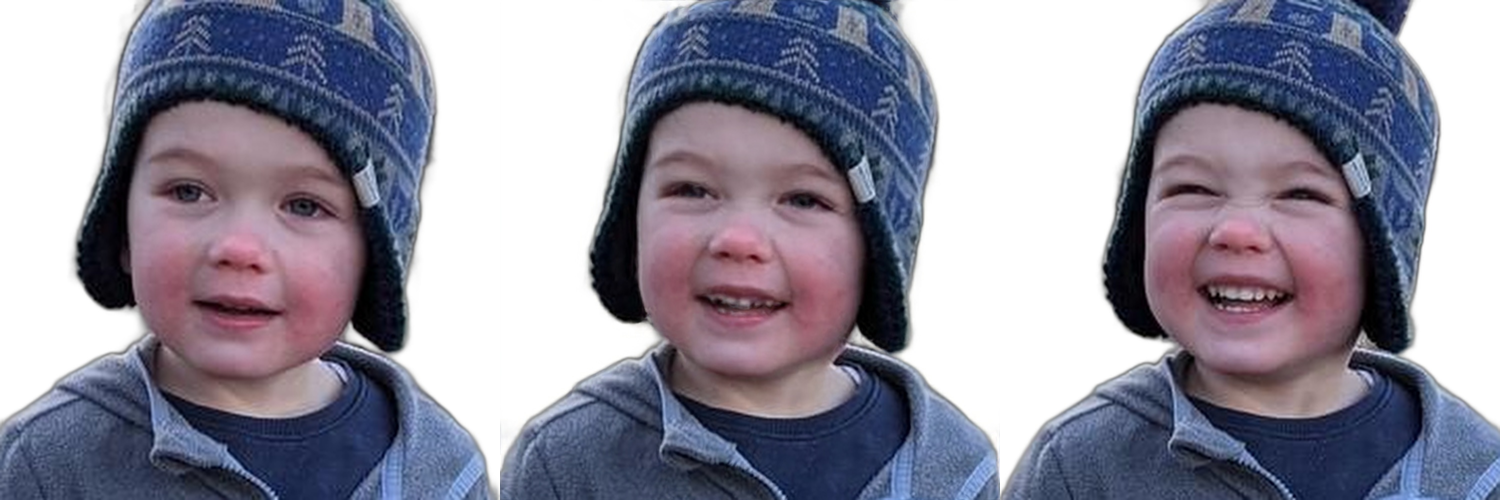

In [70]:
concat_images([frame1, output_images[0], frame2])

In [72]:
duration = 5
times_to_interpolate = int(math.log(duration*30, 2))
times_to_interpolate

7

In [73]:
output_frames = predictor.predict(frame1, frame2, times_to_interpolate=times_to_interpolate)

100%|█████████████████████████████████████████████████████████████| 127/127 [02:07<00:00,  1.00s/it]


In [74]:
# save output frames
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True) 
output_images = save_frames(output_frames, output_dir)

In [75]:

# save as video
print('Interpolated frames generated, saving now as output video.')
print('frame count:', len(output_frames))
out_path = str(output_dir) + ".mp4"
save_video(output_frames, out_path)

Interpolated frames generated, saving now as output video.
frame count: 129


In [76]:
# display video
if os.path.exists(output_dir + '.mp4'):
  video = mediapy.read_video(output_dir + '.mp4')
  mediapy.show_video(video)